<h1>I hate myself for attempting this but I'm bored</h1>
<br></br>
<h3>Let me explain myself because I feel this needs explaining:</h3>
<p>Recently, the GPT model has dominated the text-generation realm of AI (as it should, it's fucking amazing). However, I want to see how far I can push the RNN model for text generation before it can't be pushed any further. Of course, conditional text generation has been done before in the past with RNN, and very well, BUT: I am stubborn as fuck and need to experiment by myself to see what I can do. Also I just finished working on a video game and need a not so overcomplicated project to suck me back into the world of AI. I'll document my findings here in this notebook so you can see the deterioration of my sanity.</p>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
from time import sleep

from bs4 import BeautifulSoup as bs4
import requests

DESC_FILE = 'ep_descs.pkl'
TRANS_FILE = 'C:/Users/lukec/Documents/Datasets/SpongeBob_SquarePants_Transcripts/'

MAX_SEQ_LEN = 40

<h2>Problem #1: web scraping</h2>
<br></br>
<p>In order to get the generator to generate scripts from a prompt, I need to get descriptions of each episode (which will be the prompts of this generator). Fortunately, this data can be found on the Spongebob Wiki. Unfortunately, this means I have to do some mother-fucking web scraping. I'll try explain what I'm doing with comments but to be honest, I'm going to give up on that pretty quickly. Sorry in advance for my ugly python code</p>
<p>For ease of use later on, I'll store the data (which will be kept in a dictionary) into a seperate file using python's pickle</p>

In [10]:
#running for each season of spongebob
SEASONS = 13
data = {}

for season in range(1, SEASONS+1):
    page = requests.get(f"https://spongebob.fandom.com/wiki/Season_{season}#List_of_episodes").content
    
    soup = bs4(page, 'html.parser')
    table = soup.find_all('table', class_='general')[0]
        
    #let's get the title and descriptions of each episode
    titles = table.find_all('td', style='text-align:left')
    descriptions = table.find_all('td', colspan='4')
    
    for j in range(len(titles)):
        title = titles[j].text
        desc = descriptions[j].text
        #getting rid of the quotation marks around the episode name with possibly the most python line of code ever written (then also do some other pre processing)
        title = title[1:-2]
        title = title.replace(' ', '')
        title = title.lower()
        
        data[title] = desc #updating the dataset
        
#save the compiled data to a file
with open(DESC_FILE, 'wb') as f:
    pickle.dump(data, f)

print("Finished")

Finished


<p>Alright, that wasn't as bad as I thought it would be. I ended up getting the script to work on the third or fourth time. Luckily the spongebob wiki doesn't require javascript to load its shit, so I didn't have to boot up selenium to get this scraper to work. Come to think of it, this was probably the best experience I've had writing a web scraper. Nice</p>

<h1>Problem #2: bringing both datasets together</h1>
<br></br>
<p>Now that I have all the data I need, I need to compile everything into a single dataset that I can use to train the network with. This means for the transcripts, I have to clean, tokenize, and pad everything. For the episode descriptions, I need to combine the descriptions with the correct transcripts.</p>
<p>Some things to consider: RNN models are notoriously bad at generating long sequences of text. Should I set the sampling size lower so that the model performs better? Or should I keep it high so I can really test the limits of this type of model. Hmmmm.... I guess I'll figure it out as I go, but I'm pretty sure I'm going to have to set the sampling size to be smaller. I'll start with the full transcripts and go from there. I think the main reason I want to do this is because I already know how bad LSTM is at performing this task, but I haven't really tested the GRU layer that much and am curious as to how it performs. I think I'll end up training two models.</p>

<h3>Quick side note:</h3>
<p>I want to really quickly go over in text what I want the architecture of the model to be (inputs and outputs for now, I'll go into more detail when I build the model). For starters, the model will have two inputs: X1 and X2. They will store the previous text in the transcript and the prompt, respectively. The output will be a one-hot encoding of the next token to be added to the sequence. My hope with using the two seperate inputs for the model will help it perform better when generating scripts that are more relevant to the provided episode prompt. Again, GPT models handle this problem with ease, but when it comes to RNNs, I want to make sure the model remembers what it should be generating</p>
<p>I'll go with this design for as long as possible, so hopefully I don't lose my shit trying to keep this plan from failing. I have to remember that this is not going to work the first time cuz I have no clue what the fuck I'm doing.</p>

In [3]:
#let's start with the basics: loading the data from disk
dataset = {}

descs = {}
with open(DESC_FILE, 'rb') as f:
    descs = pickle.load(f)

failed_items = 0
successful_items = 0
    
for file in glob.glob(TRANS_FILE + '*.txt'):
    ep_title = file.split('\\')[1].split('.')[0]
    ep_title = ep_title.lower()
    
    #try to access the description of the episode, if it's not on file, just ignore it
    try:
        desc = descs[ep_title]
        
        lines = []
        with open(file, 'r', encoding='utf-8') as f:
            for line in f.readlines():
                lines.append(line.lower())
                #lines.extend('\n')
        
        dataset[desc] = lines
        successful_items += 1
    except:
        failed_items += 1
        continue

print(f"{failed_items} items failed to load")
print(f"{successful_items} items loaded!")

76 items failed to load
317 items loaded!


In [4]:
#alright, now let's process and organize this data (spaghetti code incoming)
print("Processing data...")

pretokenized = []
pretokenizedDescs = []

def tokenize(line):
    #not even going to explain this mess. Just know this cleans the data. Don't currently know a better way of doing this and it's killing me inside. 
    tokens = []
    for char in line:
        tokens.append(char)
    return tokens

def tokenize_words(line):
    #not even going to explain this mess. Just know this cleans the data. Don't currently know a better way of doing this and it's killing me inside. 
    tokens = []
    for word in line.split(' '):
        newword = ""
        for char in word:
            if not char.isalpha():
                if newword != "":
                    tokens.append(newword)
                newword = ""
                tokens.append(char)
            else:
                newword += char
        if(newword!=''):
            tokens.append(newword)
    return tokens

for desc in dataset:
    #clean the data
    tempdata = [x for x in dataset[desc] if x != '\n']
    tokens = []
    descTokens = []
    
    for line in tempdata:
        line += "\n"
        tokens.extend(tokenize_words(line))
        
    pretokenizedDescs.append(tokenize_words(desc.lower()))
    #removing unecessary tokens
    pretokenizedDescs[-1].pop(pretokenizedDescs[-1].index('\n'))
    
    pretokenized.append(tokens)
    
#now let's tokenize this sucker and then move on to building the dataset to be fed to the network.
lib = [''] #library of tokens
tokenized = [] #dataset tokenized
tokenizedDescs = [] #same thing but descriptions
maxLen = 0 #for padding later down the road
maxDescLen = 0 #same thing but for descriptions

#first the transcripts (calculating the maximum sequence length and then tokenizing the dataset using the lib array)
for i in pretokenized:
    if len(i) > maxLen:
        maxLen = len(i)
    for j in i:
        if j not in lib:
            lib.append(j)
            
for i in pretokenized:
    temp = []
    for j in i:
        temp.append(lib.index(j))
    tokenized.append(temp)
    
#now the descriptions
for i in pretokenizedDescs:
    if len(i) > maxDescLen:
        maxDescLen = len(i)
    for j in i: #continuing to build upon the library just in case there are some tokens that didn't make the list yet
        if j not in lib:
            lib.append(j)
            
for i in pretokenizedDescs:
    temp = []
    for j in i:
        temp.append(lib.index(j))
    tokenizedDescs.append(temp)
    
#now we need to pad the tokenized descriptions since that won't happen automatically when the dataset it built
for i, n in enumerate(tokenizedDescs):
    for j in range(maxDescLen-len(n)):
        tokenizedDescs[i].append(0) #padding (0 token represents and empty string in the lib array)

print("Finished")

Processing data...
Finished


In [9]:
from tensorflow.keras.utils import to_categorical
import random

#smallest length a sequence can be
MIN_LEN = MAX_SEQ_LEN

X1 = [] #ep descriptions
X2 = [] #prev tokens
Y = []  #ep transcipts

#helper to generate random batches of data from the main dataset
#loading the whole dataset to memory at one time on my 16GB of ram would fry my computer pretty quickly. Let's avoid that
def get_dataset(batch_size, size=MAX_SEQ_LEN):
    X1 = []
    X2 = []
    Y = []
    for batch in range(batch_size):
        rand_trans = random.randrange(MIN_LEN, len(tokenized)) #get a random transcript to get information from
        rand_start = random.randrange(0, len(tokenized[rand_trans])-size)
        
        temp = tokenized[rand_trans][rand_start:rand_start+size]

        X1.append(np.array(temp))
        X2.append(tokenizedDescs[rand_trans])
        Y.append(tokenized[rand_trans][rand_start+size])
        
    X1 = np.array(X1, dtype='float32')
    X2 = np.array(X2, dtype='float32')
    Y = np.array(Y)
    
    Y = to_categorical(Y, num_classes=len(lib))
    return X1, X2, Y

<h1>Problem #3: Building the model</h1>
<br></br>
<p>Gettting the data prepped is always the most annoying and difficult part. This time (for me at least) was no exception. I spent a good 2 hours writing the above cells, and now I'm ready to move on. Luckily, with everything put into place, it should IN THEORY be easy to set this model up.</p>
<p>I already went over the plan in an above cell, so I won't explain myself again. This is already a stupid idea, I'm just going to roll with it at this point. I'm going to start with one GRU layer for each input layer, and then move on from there depending on how the model performs. I'll make sure to update this cell if I decide to change the model design drastically (which I most likely will do). I also plan on comparing the difference in performance between a LSTM model and a GRU model, so I'll document my findings later down the line. I feel like GRU will perform better, but I'll test both models just to be sure.</p>

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, LSTM, Dropout, BatchNormalization, concatenate, TimeDistributed, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

def GRUModel():
    #transcript input
    x_in = Input(shape=(MAX_SEQ_LEN))
    
    x = Embedding(len(lib), 20, input_length=1)(x_in)
    
    x = GRU(128)(x)
    
    x = Model(inputs=x_in, outputs=x)
    
    #descriptions input
    y_in = Input(shape=(maxDescLen))
    
    y = Embedding(len(lib), 20, input_length=1)(y_in)
    
    y = GRU(64)(y)
    
    y = Model(inputs=y_in, outputs=y)
    
    #models combined
    z = concatenate([x, y])
    
    z = Dense(128)(z)
    z = LeakyReLU()(z)
    z = Dropout(0.2)(z)
    
    z = Dense(len(lib), activation='softmax')(z)
    
    z = Model(inputs=[x_in, y_in], outputs=z)
    return z

def LSTMModel():
    #transcript input
    x_in = Input(shape=(MAX_SEQ_LEN))
    
    x = Embedding(len(lib), 20, input_length=1)(x_in)
    
    x = LSTM(128)(x)
    
    x = Model(inputs=x_in, outputs=x)
    
    #descriptions input
    y_in = Input(shape=(maxDescLen))
    
    y = Embedding(len(lib), 20, input_length=1)(y_in)
    
    y = LSTM(64)(y)
    
    y = Model(inputs=y_in, outputs=y)
    
    #models combined
    z = concatenate([x.output, y.output])
    
    z = Dense(128)(z)
    z = LeakyReLU()(z)
    z = Dropout(0.2)(z)
    
    z = Dense(len(lib), activation='softmax')(z)
    
    z = Model(inputs=[x_in, y_in], outputs=z)
    return z

In [11]:
model = LSTMModel()

opt = Adam(learning_rate=0.0003)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 39)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 20)       357340      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 39, 20)       357340      input_4[0][0]                    
____________________________________________________________________________________________

Epoch 1000/1000: LOSS=5.513247489929199    ACC=0.09375
Finished


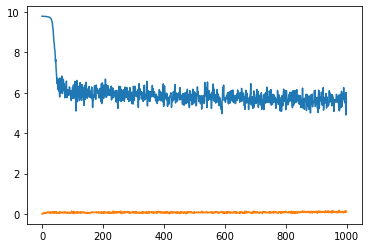

In [12]:
#fitting the model (please god please work please)
from IPython.display import clear_output

epochs = 1000
batch_size = 128

losses = []

for i in range(epochs):
    #generate some data
    X1, X2, Y = get_dataset(batch_size, MAX_SEQ_LEN)

    #train the network
    loss = model.train_on_batch([X1, X2], Y)
    losses.append(loss)
    
    clear_output(wait=True)
    print(f"Epoch {i+1}/{epochs}: LOSS={loss[0]}    ACC={loss[1]}")

print("Finished")
model.save("SpongeBobLSTM.h5")
plt.plot(losses)

<h1>Problem #4: Testing the model</h1>
<br></br>
<p>Now that I have a trainable model, I need a way of testing it's capabilities outside of a graph. My goal is to create a program that takes a prompt, tokenizes and processes the prompt, and then passes it through the model until the model generates a story as big as what it can take as input (if that makes any sense). Hopefully the code should explain itself for this one as I'll be using a lot of the code I already written.</p>

In [13]:
from tqdm.notebook import tqdm as log_progress
from tensorflow.keras.models import load_model

def shift(arr, new=0.0):
    for i in range(1, len(arr[0])):
        arr[0][i-1] = arr[0][i]
    arr[0][-1] = new

model = load_model("SpongebobLSTM.h5")

#how many tokens to take from the actual dataset 
start_seq_len = MAX_SEQ_LEN
EP_LEN = 50 #how many times the program should run

prompt = input("Enter prompt for episode: ")
prompt = prompt.lower()

#tokenize the prompt if it's short enough
if len(prompt.split(' ')) < maxDescLen:
    tokens = tokenize_words(prompt)
    ep_prompt = []
    
    for i in tokens:
        if i in lib:
            ep_prompt.append(lib.index(i))
        else:
            ep_prompt.append(0)
            
    for i in range(maxDescLen-len(ep_prompt)):
        ep_prompt.append(0)
        
    ep_prompt = np.array(ep_prompt)
    ep_prompt = np.reshape(ep_prompt, (1, ep_prompt.shape[0]))
    
    #create a temp array to hold the previous tokens of the generated story
    episode = []
    
    temp = np.zeros((1, MAX_SEQ_LEN))
    temp[0][0:start_seq_len] = random.choice(tokenized)[0:start_seq_len]
    
    for i in range(start_seq_len):
        episode.append(int(temp[0][i]))
    
    for i in log_progress(range(EP_LEN)):
        next_token = model.predict([temp, ep_prompt], verbose=0)
        episode.append(int(next_token[0].argmax()))
        shift(temp, new=next_token[0].argmax())
        
    #finally print the finished story
    episode_script = ''
    for i in episode:
        episode_script += lib[i] + ' '
        
    print(episode_script)
else:
    print("Prompt is too long!")

Enter prompt for episode: Spongebob finds a hidden sea shell and sells it to patrick



[ pan over live - action houses ] 
 
 french narrator : we take you now to encino , california , where we find the president of the spongebob squarepants fan club . . flipping burgers ? ! 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 


<h2>Some notes:</h2>
<ol>
    <li>Embedding layer might not be that useful. I'm just trying to understand and generate sequences, not get the AI to understand the difference between words.</li>
    <li>If embedding layers are useless, switching to a character based tokenization might be better than the word based tokenization method I'm using now.</li>
    <li>The AI currently does not seem to understand any differences. I've changed the architecture of the model several times with no change in it's performance, so I'm going to guess the problem lies with how I'm feeding and prepping the data.</li>
</ol>
<br></br>
<h3>Performance notes after changing data to character-based tokenization:</h3>
<ul>
    <li>Doesn't seem to be any change in performance, but I just started with this new strategy, so I'm going to put a little more work into it.</li>
    <li>Not sure if it was the character based tokenization or the fact that the model isn't training on empty inputs anymore (no more 0 padding in training data), but the model is now actually performing better. I also simplified the model a bit to only take one input (previous tokens) in order to debug the lack of learning, which also could contribute to this boost in performance. I'm going to add back the second input with this new method and see if there's any changes.</li>
    <li>It seems to be the fact that input data is no longer padded that the model is performing better than ever. I am going to try and go back to the old tokenization method to see if that will change anything.</li>
</ul>

<h3>Notes after changing back to word-based tokenization:</h3>
<ul>
    <li>I included the loss (blue) and accuracy (orange) graph below:</li>
    <img src='Graph1.png'>
    <li>As you can see, the training is unstable as fuck, but it is slowly getting better over time, which is good. I'm going to add back the second input as well as testing the model with what it can currently produce. After making those changes, I got this graph:</li>
    <img src='Graph2.png'>
    <li>No idea what the fuck happened here. Amazing how the loss started so high at first, but that might be just from the extra neurons I threw into the model. To make sure the first input isn't the only part of the model training, I'll add some dropout to both inputs and also mess with the Embedding layers for both inputs.</li>
    <li>So this is disappointing:</li>
    <img src='Graph3.png'>
    <li>It seems that the model is no longer improving after training some more... This is annoying.</li>
</ul>
<br></br>
<h3>Let's talk validation data:</h3>
<h4>(and why this approach I'm taking is terrible)</h4>
<p>Many people who aren't trying to kill their careers in ML will use validation data to make sure their model is actually learning rather than memorizing a dataset. This is smart. It introduces new data to the model that it hasn't seen before and allows for programmers to see if their model is overfitting or not. So why am I not using validation data?</p>
<br></br>
<p>Well, the answer is simple. <b>I'm stupid and stubborn</b>. I am feeding the network very little data. You might say "there's so much training data in the episode transcripts, you have no excuse", and you're right, but I am also feeding to the network the descriptions for each episode, which is very little information to the network. There's only so many descriptions, and while I can split up the transcripts to get more training data, I can't split up sequences as little as descriptions, especially when I need the whole desc sequence to actually represent a description for an episode.</p>
<p>I mean, if I'm being honest it's not the worse solution. I mean, think about it: In theory this will produced an overfitted model that generates infinite episodes given the topic of any existing spongebob episode. In theory, at least.</p>
<br></br>
<h3>A slightly better approach:</h3>
<h4>(Apart from using something like the GPT model)</h4>
<p>Transfer learning. Use a model that already has a fully trained Embedding and LSTM/GRU layer and slap it to the top of my model. This would give the model a giant boost, but I'm still not sure how well it would do. Might experiment with this in the future...</p>

<br></br>

<h1>Results:</h1>
<h4>(Prompt used: Spongebob finds a rare sea shell)</h4>

<br></br>

<h3>GRU Model:</h3>
<p>After 1000 epochs:</p>
<img src='Results1.png'>
<p>After 2000 epochs: (Seems like it's getting better(?))</p>
<img src='Results2.png'>
<p>After 3000 epochs:</p>
<p>No image here because the output is just a bunch of whitespace interrupted by a lot of periods and the occasional "squidward"...</p>
<br></br>
<p>Damn it</p>
<br>After 4000 epochs:</br>
<p>...It's just whitespace</p>
<p><b>FUCK</b></p>
<br></br>
<p>Well, hopefully I can maybe salvage this experiment by getting some interesting results with LSTM to compare to GRU.</p>
<br></br>

<h3>LSTM Model:</h3>
<p>After 1000 epochs:</p>
<img src='Results3.png'>
<p>After 2000 epochs: (noticing a trend here)</p>
<img src='Results4.png'>
<p>After 3000 epochs:</p>
<img src='Results5.png'>
<p>After 4000 epochs:</p>
<p>Whitespace again...</p>

<br></br>

<p>Alright, back to the drawing board.</p>

<h2>Notes about the old method:</h2>
<ul>
    <li>It overfits like crazy.</li>
    <li>When I refer to an "epoch", it's not a true epoch, but rather one batch of data going through the model. I can't be bothered to change this, so from now on that's what I'm referring to when I say something like "one epoch of training".</li>
</ul>

<br></br>

<h1>New Plan:</h1>
<p>Let's ditch the old plan of providing a description for each episode generated. That's going to introduce a lot of headaches in terms of prepping the data and somehow not overfitting the model.</p>
<p>Alright, cool, now the whole experiment can be shut down. However, I still want to make something from this failed project so that I don't feel like this was a waste of time (which it probably was but who cares, it's fun). My new plan is this:</p>
<ol>
    <li>Ditch the description input side of the model.</li>
    <li>Make a simple, generic RNN model using either GRU or LSTM to generate sequences of text that will hopefully resemble an episode of spongebob.</li>
    <li>To provide a way for the user to have at least <i>some</i> control over what the program generates, the user will be able to input the first n number of tokens for the model to start generating with.</li>
    <li>Also, since I want to use the descriptions in some way, pass in either a random pre-determined description or a vector representing a specific spongebob episode (one hot encoded). My hope for this is this will allow users to guide the output of the model to follow a theme similar to a specific episode of spongebob.</li>
</ol>

<br></br>
<p>Hopefully with these changes, the model will perform better while still offering a little control to the user.</p>

<h1>Fuck-up #1:</h1>
<p>I'm so dumb. When making the model, I concatenated the inputs of the two input models, rather than their outputs. This lead to the GRU and LSTM layers to <b>NOT EVEN RUN</b> when training. Re-running the training algorithm now to see if I can fix my fuck up.</p>

<h1>After fixing the fuck-up:</h1>
<p>My previous observations and notes are still correct, and the model is still producing whitespace as output, only it reaches this point a lot faster in the training process, which sucks but at least I didn't write a ton of notes for nothing.</p>

In [5]:
#get our old imports
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, LSTM, Dropout, BatchNormalization, concatenate, TimeDistributed, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

from tqdm.notebook import tqdm as log_progress
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import to_categorical
import random

In [31]:
#smallest length a sequence can be
MIN_LEN = MAX_SEQ_LEN

X1 = [] #ep descriptions
X2 = [] #prev tokens
Y = []  #ep transcipts

#Let's make the new model
def V2Model():
    #transcript input
    x_in = Input(shape=(MAX_SEQ_LEN))
    
    x = Embedding(len(lib), 20, input_length=1)(x_in)
    
    x = GRU(128, return_sequences=True)(x)
    x = GRU(128)(x)
    
    x = Model(inputs=x_in, outputs=x)
    
    #one hot encoded of what episode theme should be used (might not use this)
    y_in = Input(shape=(successful_items)) #successful items is the number of episodes successfully loaded from the dataset
    
    y = Dense(128)(y_in)
    y = LeakyReLU()(y)
    y = Dropout(0.2)(y)
    
    y = Model(inputs=y_in, outputs=y)
    
    #combined models
    z = concatenate([x.output, y.output])
    
    z = Dense(128)(z)
    z = LeakyReLU()(z)
    z = Dropout(0.2)(z)
    
    z = Dense(len(lib), activation='softmax')(z)
    z = Model(inputs=[x_in, y_in], outputs=z)
    return z
    

#next we need a new way of preparing datasets for the new network
def get_dataset(batch_size):
    X1 = []
    X2 = []
    Y = []
    for batch in range(batch_size):
        rand_trans = random.randrange(0, len(tokenized)) #get a random transcript to get information from
        rand_start = random.randrange(0, len(tokenized[rand_trans])-MAX_SEQ_LEN)
        
        temp = tokenized[rand_trans][rand_start:rand_start+MAX_SEQ_LEN]
        
        #one hot encoding of which episode theme should the AI use. 
        one_hot = np.zeros((successful_items))
        one_hot[rand_trans] = 1
        
        X1.append(np.array(temp))
        X2.append(one_hot)
        Y.append(tokenized[rand_trans][rand_start+MAX_SEQ_LEN])
        
    X1 = np.array(X1, dtype='float32')
    X2 = np.array(X2, dtype='float32')
    Y = np.array(Y)
    
    Y = to_categorical(Y, num_classes=len(lib))
    return X1, X2, Y

#and finally, we need a new training loop
#it's not going to be much different from the old training model, but I feel like it's just more organized to have a method
#for everything new I'm adding / changing
def train(model, epochs, batch_size, name="Model.h5"):
    losses = []

    for i in range(epochs):
        #generate some data
        X1, X2, Y = get_dataset(batch_size)

        #train the network
        loss = model.train_on_batch([X1, X2], Y)
        losses.append(loss)

        clear_output(wait=True)
        print(f"Epoch {i+1}/{epochs}: LOSS={loss[0]}    ACC={loss[1]}")

    print("Finished")
    model.save(name)
    plt.plot(losses)

In [32]:
model = V2Model()

opt = Adam(learning_rate=0.0003)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 317)]        0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 40, 20)       357340      input_19[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 128)          40704       input_20[0][0]                   
___________________________________________________________________________________________

In [33]:
NAME = "SpongeBobV2.h5"
EPOCHS = 2000
BATCH_SIZE = 128

train(model, EPOCHS, BATCH_SIZE, name=NAME)

Epoch 826/2000: LOSS=6.005267143249512    ACC=0.046875


KeyboardInterrupt: 

<h1>New model performance notes:</h1>
<p>Right away the model is performing a ton better than method #1. The loss is dropping while the accuracy is rising. This is a good sign as it shows that there is much less overfitting taking place. I still have to write a new script to properly test the model, but the graphs are looking much better so far, and I am less sad.</p>